In [54]:
import sys, os

import numpy as np

import scipy
from scipy import optimize


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
current_palette = sns.color_palette()

In [55]:
from thurner_model import NoiseTrader, Fund, DynamicFund, find_equilibrium 
import plotting

In [56]:
class Env:
    """
    Docstring
    """
    # Define our fundamental value V and asset-supply N
    V = 1.
    N = 1000.
    
    initial_price = 1.
    
    # Define noise trader (uses the NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        # tracks trader spending, this is not observed by the fund
        # therefore it is not in the environment's state
        
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending
        
        
    # when resetting the environment, we set its state back to the initial state
    def reset(self):
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending

    def step(self, funds):
        """Finds equilibrium, and updates environment parameters""" 
        # keep track of old price for processing inflows
        p_tm1 = self.p_t
        
        # 1. Find the new price for the timestep
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)

        self.p_t = find_equilibrium(self.xi_t, funds)
        
        # 2. update the holdings of all the funds (wealth, shares and cash)
        current_wealth = []
        for fund in funds:
            fund.update_holdings(self.p_t)
            fund.check_and_make_bankrupt(self.p_t)
            fund.process_inflows(p_tm1, self.p_t)
            current_wealth.append(fund.get_wealth(self.p_t))
        
        return current_wealth

# Run the simulation

In [57]:
prices = []
funds_wealth = []

# Create the environment

number_of_funds = 10
funds = [DynamicFund((i+1)*5) for i in range(number_of_funds)]

# set initial situation
env = Env()
env.reset()

for i in range(10000):
    #take a step in the environment
    current_wealth = env.step(funds)

    # record the current price and wealth of all funds
    prices.append(env.p_t)
    funds_wealth.append(current_wealth)

In [58]:
# show betas of the funds used
[f.beta for f in funds]

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

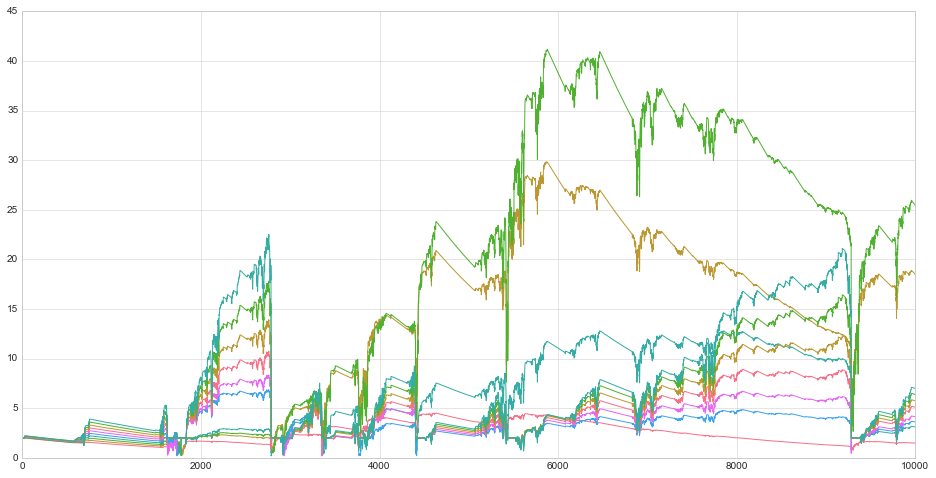

In [59]:
plt.figure(figsize=(16,8))
with sns.color_palette("husl"):
    plt.plot(funds_wealth);

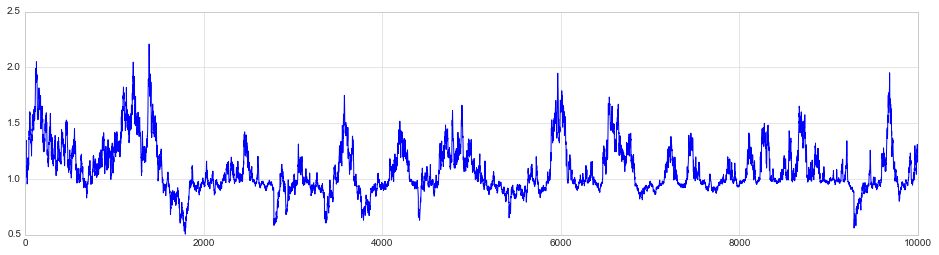

In [60]:
plt.figure(figsize=(16,4))
plt.plot(prices);

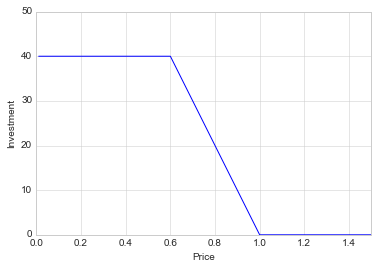

In [61]:
V = 1
def test_fund_demand():
    testFund = Fund(50)
    
    prices = []
    demand = []
    for i in range(-99, 100):
        price = V + i / 100
        investment = testFund.get_demand(price) * price
        prices.append(price)
        demand.append(investment)
        
    plt.xlabel('Price')
    plt.ylabel('Investment')
    plt.axis([0.0, 1.5, 0, 50])
    plt.plot(prices, demand);
test_fund_demand()

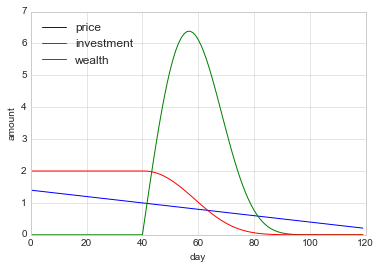

In [62]:
fund = Fund(30)

days = []
prices = []
wealth = []
investment = []
for i in range(0,120):
    price = 1.4 - i/100
    fund.update_holdings(price)
    days.append(i)
    prices.append(price)
    wealth.append(fund.get_wealth(price))
    investment.append(fund.shares * price)
    
plt.plot(days, prices, 'b', label='price')
plt.plot(days, investment, 'g', label='investment')
plt.plot(days, wealth, 'r', label='wealth')
plt.xlabel('day')
plt.ylabel('amount')
plt.legend(loc='upper left');